AML DETECTION WITH LOGISTIC REGRESSION
Data loaded: 5,078,345 transactions
Target distribution:
Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

Creating AML-specific features...
Features selected: 19
Class balance - Legitimate: 5,073,168, Laundering: 5,177

Train set: 4,062,676 transactions
Test set: 1,015,669 transactions

Training Logistic Regression...

MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93   1014634
           1       0.01      0.88      0.01      1035

    accuracy                           0.88   1015669
   macro avg       0.50      0.88      0.47   1015669
weighted avg       1.00      0.88      0.93   1015669


ROC AUC Score: 0.9241

Confusion Matrix:
True Negatives: 887,918
False Positives: 126,716
False Negatives: 121
True Positives: 914

FEATURE IMPORTANCE (TOP 10)

Top 10 Most Important Features:
 1. payment_format_encoded    ↓ DECREASES laundering risk (

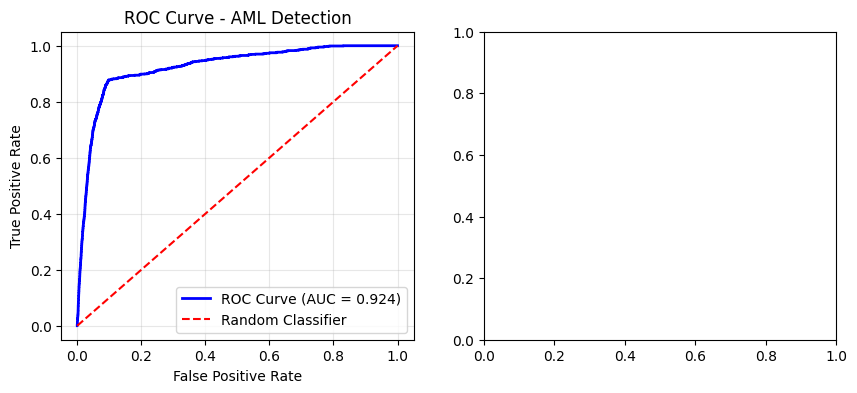

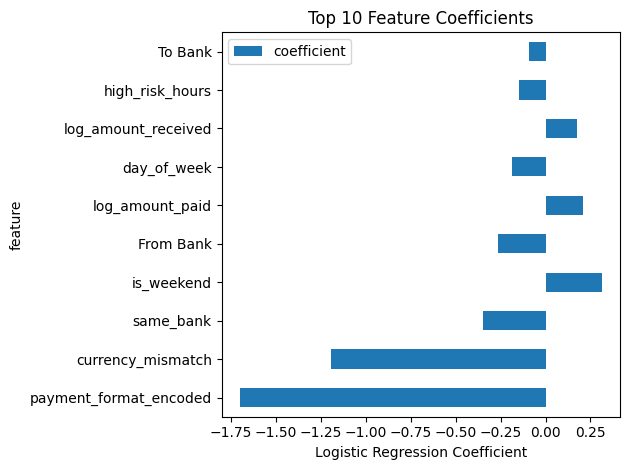


BUSINESS INTERPRETATION

📊 OPERATIONAL METRICS:
  • Total transactions analyzed: 1,015,669
  • Transactions flagged as suspicious: 127,630 (12.57%)
  • Model accuracy: 87.51%

🚨 ALERT VOLUME AT DIFFERENT RISK THRESHOLDS:
  • Threshold 0.3: 221,847 alerts (21.84% of transactions)
  • Threshold 0.5: 127,630 alerts (12.57% of transactions)
  • Threshold 0.7: 97,302 alerts (9.58% of transactions)
  • Threshold 0.9: 21,150 alerts (2.08% of transactions)

💡 KEY INSIGHTS:
  • Strongest risk indicator: payment_format_encoded
  • Currency mismatches decrease laundering risk
  • Model is needs improvement (AUC: 0.924)


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("AML DETECTION WITH LOGISTIC REGRESSION")
print("="*50)

# 1. Load data
df = pd.read_csv('HI-Small_Trans.csv')
print(f"Data loaded: {df.shape[0]:,} transactions")
print(f"Target distribution:\n{df['Is Laundering'].value_counts()}")

# 2. Feature Engineering for AML Detection
print("\nCreating AML-specific features...")

# Convert timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Amount-based features
df['amount_difference'] = abs(df['Amount Received'] - df['Amount Paid'])
df['amount_ratio'] = df['Amount Received'] / (df['Amount Paid'] + 1e-8)  # Avoid division by zero
df['log_amount_received'] = np.log1p(df['Amount Received'])
df['log_amount_paid'] = np.log1p(df['Amount Paid'])

# Currency features
df['currency_mismatch'] = (df['Receiving Currency'] != df['Payment Currency']).astype(int)

# Bank features
df['same_bank'] = (df['From Bank'] == df['To Bank']).astype(int)

# Account features (encode account patterns)
le_account = LabelEncoder()
le_account1 = LabelEncoder()
le_payment_format = LabelEncoder()
le_recv_currency = LabelEncoder()
le_pay_currency = LabelEncoder()

df['account_encoded'] = le_account.fit_transform(df['Account'].astype(str))
df['account1_encoded'] = le_account1.fit_transform(df['Account.1'].astype(str))
df['payment_format_encoded'] = le_payment_format.fit_transform(df['Payment Format'])
df['recv_currency_encoded'] = le_recv_currency.fit_transform(df['Receiving Currency'])
df['pay_currency_encoded'] = le_pay_currency.fit_transform(df['Payment Currency'])

# Risk indicators commonly used in AML
# Round amount indicator (suspicious if amounts are round numbers)
df['round_amount_received'] = (df['Amount Received'] % 1000 == 0).astype(int)
df['round_amount_paid'] = (df['Amount Paid'] % 1000 == 0).astype(int)

# High-risk hours (early morning/late night transactions)
df['high_risk_hours'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)

# 3. Select features for logistic regression
feature_columns = [
    'From Bank', 'To Bank',
    'Amount Received', 'Amount Paid', 
    'log_amount_received', 'log_amount_paid',
    'amount_difference', 'amount_ratio',
    'currency_mismatch', 'same_bank',
    'hour', 'day_of_week', 'is_weekend', 'high_risk_hours',
    'round_amount_received', 'round_amount_paid',
    'payment_format_encoded', 'recv_currency_encoded', 'pay_currency_encoded'
]

X = df[feature_columns].copy()
y = df['Is Laundering'].copy()

print(f"Features selected: {len(feature_columns)}")
print(f"Class balance - Legitimate: {(y==0).sum():,}, Laundering: {(y==1).sum():,}")

# 4. Handle missing values and infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]:,} transactions")
print(f"Test set: {X_test.shape[0]:,} transactions")

# 6. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Train Logistic Regression
print("\nTraining Logistic Regression...")

# Use class_weight='balanced' to handle imbalanced data
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train)

# 8. Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# 9. Evaluate performance
print("\n" + "="*50)
print("MODEL PERFORMANCE")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives: {cm[1,1]:,}")

# 10. Feature Importance (Logistic Regression Coefficients)
print("\n" + "="*50)
print("FEATURE IMPORTANCE (TOP 10)")
print("="*50)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    direction = "↑ INCREASES" if row['coefficient'] > 0 else "↓ DECREASES"
    print(f"{i+1:2d}. {row['feature']:<25} {direction} laundering risk (coef: {row['coefficient']:.4f})")

# 11. Plot ROC Curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AML Detection')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
feature_importance.head(10).plot(x='feature', y='coefficient', kind='barh')
plt.title('Top 10 Feature Coefficients')
plt.xlabel('Logistic Regression Coefficient')
plt.tight_layout()
plt.show()

# 12. Real-world interpretation
print("\n" + "="*50)
print("BUSINESS INTERPRETATION")
print("="*50)

total_transactions = len(y_test)
flagged_transactions = (y_pred_proba > 0.5).sum()
flagged_rate = flagged_transactions / total_transactions * 100

print(f"\n📊 OPERATIONAL METRICS:")
print(f"  • Total transactions analyzed: {total_transactions:,}")
print(f"  • Transactions flagged as suspicious: {flagged_transactions:,} ({flagged_rate:.2f}%)")
print(f"  • Model accuracy: {(y_pred == y_test).mean()*100:.2f}%")

# Risk threshold analysis
thresholds = [0.3, 0.5, 0.7, 0.9]
print(f"\n🚨 ALERT VOLUME AT DIFFERENT RISK THRESHOLDS:")
for threshold in thresholds:
    alerts = (y_pred_proba > threshold).sum()
    alert_rate = alerts / total_transactions * 100
    print(f"  • Threshold {threshold}: {alerts:,} alerts ({alert_rate:.2f}% of transactions)")

print(f"\n💡 KEY INSIGHTS:")
top_risk_factor = feature_importance.iloc[0]
print(f"  • Strongest risk indicator: {top_risk_factor['feature']}")
print(f"  • Currency mismatches {'increase' if feature_importance[feature_importance['feature'] == 'currency_mismatch']['coefficient'].values[0] > 0 else 'decrease'} laundering risk")
print(f"  • Model is {'well-balanced' if 0.7 <= roc_auc_score(y_test, y_pred_proba) <= 0.9 else 'needs improvement'} (AUC: {roc_auc_score(y_test, y_pred_proba):.3f})")